In [315]:
import sys

import pandas as pd
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import paleobeasts as pb
from paleobeasts.signal_models import ebm as pb_ebm
import paleobeasts.utils.utilities as pbu


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [316]:
T_init = [288]
length = 10000
t_i = 0
t_f = t_i+length
delta_t=.5

In [317]:
periods_powers = [(11, .40), (90, .80), (200, 1.15)]
forcing_func = pbu.create_periodic_forcing_function(periods_powers, desired_amplitude=3, y0=1360/4)


## 1. EBM with function as forcing

In [318]:
ebm_forcing = pb.Forcing(forcing_func)
ebm = pb_ebm.EBM(forcing=ebm_forcing, albedo=pb_ebm.albedo_func)
ebm_rk45 = pb.Solver(ebm, (t_i, t_f), T_init, kwargs={'max_step':.1})
ebm_rk45.integrate()

In [319]:
for key in ebm.diagnostic_variables.keys():
    print(key, ebm.diagnostic_variables[key][-1])

albedo 0.3016158197035886
absorbed_SW 238.10188958499685
OLR 237.77264763559532
solar_incoming 340.93253584859343
time 10000.0


## 2. EBM with data array as forcing (sampled function output)

In [302]:
integration_time = np.arange(t_i, t_f+100, 4)
ebm_forcing2 = pb.Forcing(forcing_func(integration_time), time=integration_time, interpolation='linear')

data is an array


In [303]:
ebm_2 = pb_ebm.EBM(forcing=ebm_forcing2, albedo=pb_ebm.albedo_func)
ebm_rk45_2 = pb.Solver(ebm_2, (t_i, t_f), T_init, kwargs={'max_step':.1})
ebm_rk45_2.integrate()

In [304]:
for key in ebm_2.diagnostic_variables.keys():
    print(key, ebm_2.diagnostic_variables[key][-1])
ebm_rk45_2.solution.y[-1]

albedo 0.3015889278442564
absorbed_SW 238.11105789479262
OLR 237.8334539482545
solar_incoming 340.93253584859343
time 10000.0


array([287.81670352])

Text(0, 0.5, 'forcing')

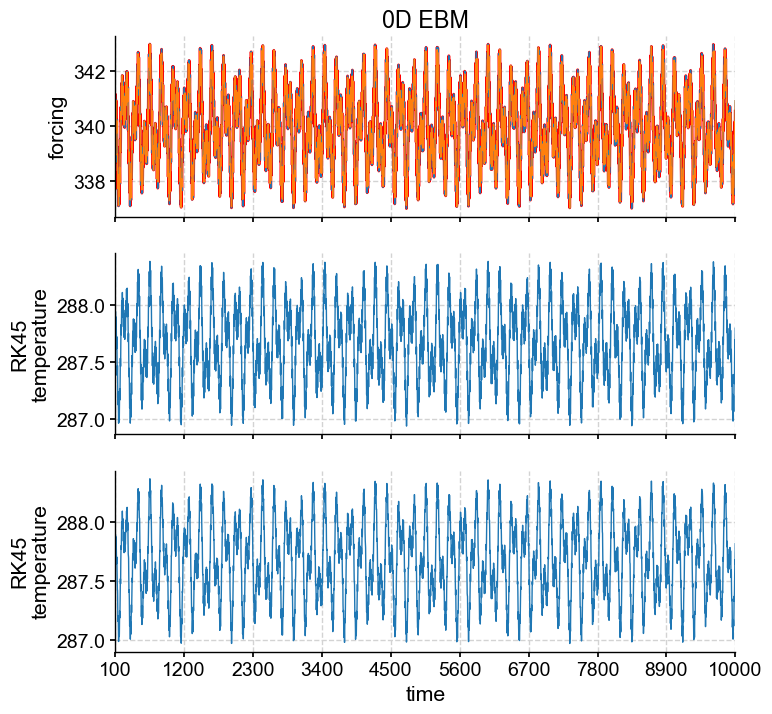

In [305]:
end_kya=t_f
plot_time_length = length-100
start_kya=end_kya-plot_time_length

model_sols = [ebm_rk45, ebm_rk45_2]

t_range = np.arange(start_kya, end_kya, 1)
ticks = np.linspace(start_kya, end_kya, 10)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(model_sols)+1, 1, sharex=True, figsize=(8, 8))

for ik, model_sol in enumerate(model_sols):
    time = model_sol.solution.t#['t_arr']
    time_mask = time>=start_kya
    model_sol_y = model_sol.solution.y[:,0]
     
    model_forcing = model_sol.model.forcing.get_forcing(time[time_mask])
    label=None#','.join([r'$v_c=$'+str(model_sol.model.vc)])
    ax[ik+1].plot(time[time_mask], model_sol_y[time_mask], linewidth=1,label=label) # marker='o', markersize=4, 
        
    ax[ik+1].legend()
    if ik ==0:
        ax[0].plot(t_range, model_sol.model.forcing.get_forcing(t_range), label='smooth', color='red')
    ax[0].plot(time[time_mask], model_forcing, linewidth=1, label=label)

    ax[ik+1].set_xticks(ticks)
    ax[ik+1].set_ylabel('\n'.join([model_sol.method,model_sol.model.variable_name]))
    ax[ik+1].set_xlim([start_kya, end_kya])
    
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time')
ax[0].set_xlim([start_kya, end_kya])
ax[0].set_title('0D EBM')
ax[0].set_ylabel('forcing')

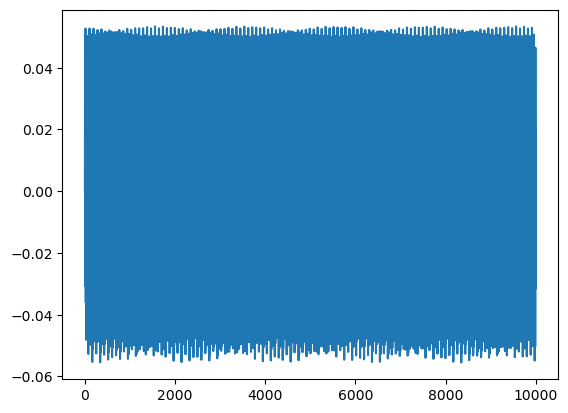

In [242]:
plt.plot(model_sols[0].solution.t, model_sols[0].solution.y[:,0]-model_sols[1].solution.y[:,0])

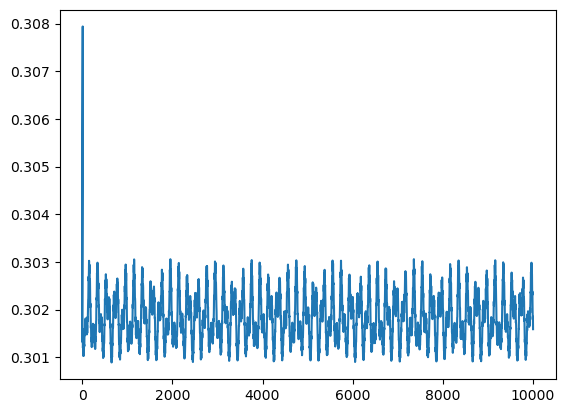

In [244]:
plt.plot(np.array(ebm_2.diagnostic_variables['time']),np.array(ebm_2.diagnostic_variables['albedo']))

In [232]:
ebm_2.diagnostic_variables['albedo']

array([0.30133333, 0.30793813, 0.30133929, ..., 0.30159005, 0.30158893,
       0.30158893])

## 3. EBM with TSI (Vieira et al. 2011) as forcing

In [306]:
import os
from pathlib import Path
proj_dir = Path(os.getcwd()).parent

In [307]:
import pandas as pd
tsi_data = pd.read_csv(proj_dir/'data/vieira_tsi.csv')
years = [int(col) for col in tsi_data.columns if col.strip('-').isnumeric()==True]
year_cols = [col for col in tsi_data.columns if col.strip('-').isnumeric()==True]

tsi_array = tsi_data[year_cols].iloc[0].values

# tsi_data.columns[0].isnumeric(), tsi_data.columns[0]

In [308]:
tsi_time = np.array([yr+8045 for yr in years])

In [309]:
tsi_forcing = pb.Forcing(.25*(tsi_array+1360), time=tsi_time, interpolation='linear')

data is an array


In [310]:
ebm_tsi = pb_ebm.EBM(forcing=tsi_forcing, albedo=pb_ebm.albedo_func)
ebm_tsi_rk45 = pb.Solver(ebm_tsi, (min(tsi_time), max(tsi_time)), T_init, kwargs={'max_step':.1})
ebm_tsi_rk45.integrate()

In [311]:
for key in ebm_tsi.diagnostic_variables.keys():
    print(key, ebm_tsi.diagnostic_variables[key][-1])
ebm_tsi_rk45.solution.y[-1]

albedo 0.3018506104293448
absorbed_SW 237.26133735782113
OLR 237.26235575340053
solar_incoming 339.84322109589044
time 7840.0


array([287.64376756])

In [312]:
ebm_tsi = pb_ebm.EBM(forcing=tsi_forcing, albedo=pb_ebm.albedo_func)
ebm_tsi_euler = pb.Solver(ebm_tsi, (min(tsi_time), max(tsi_time)), T_init, method='euler', kwargs={'dt':10})
ebm_tsi_euler.integrate()

/Users/jlanders/PycharmProjects/PaleoBeasts/paleobeasts/signal_models/ebm.py:89: RuntimeWarning: overflow encountered in scalar power
  return phys.sigma * (Te ** 4.)


In [313]:
for key in ebm_tsi.diagnostic_variables.keys():
    print(key, ebm_tsi.diagnostic_variables[key][-1])
ebm_tsi_euler.solution.y[-1]

albedo 0.6
absorbed_SW 135.94132153424658
OLR inf
solar_incoming 339.85330383561643
time 7830.0


array([-inf])

/var/folders/9h/cx1bp4z95ldcks7z_7lm3h280000gn/T/ipykernel_66827/1418862675.py:20: RuntimeWarning: invalid value encountered in subtract
  ax[ik+1].plot(time[time_mask], model_sol_y[time_mask]-np.mean(model_sol_y[time_mask]), linewidth=1,label=label) # marker='o', markersize=4,


Text(0, 0.5, 'forcing')

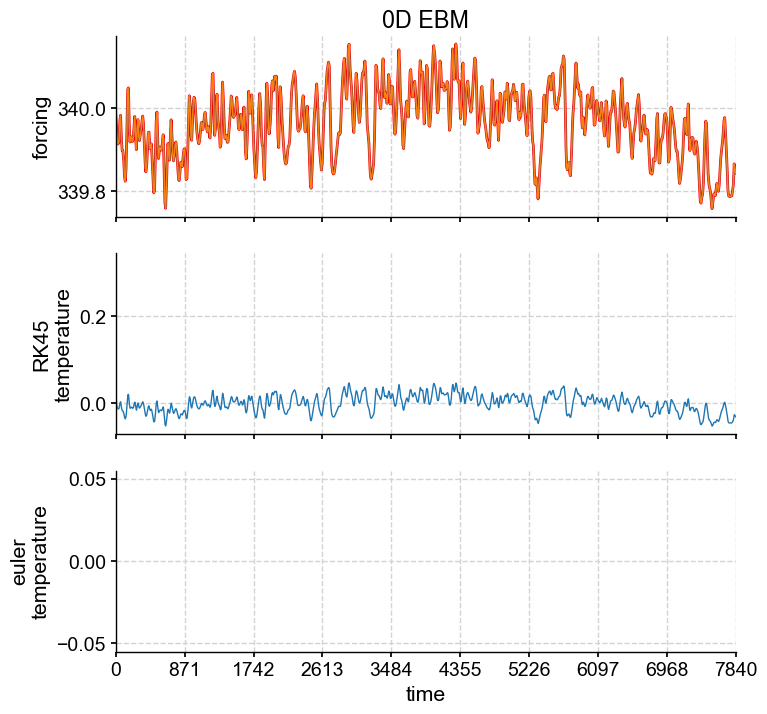

In [314]:
end_kya=max(tsi_time)
# plot_time_length = length-100
start_kya=min(tsi_time)#end_kya-plot_time_length

model_sols = [ebm_tsi_rk45, ebm_tsi_euler]

t_range = np.arange(start_kya, end_kya, 1)
ticks = np.linspace(start_kya, end_kya, 10)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(model_sols)+1, 1, sharex=True, figsize=(8, 8))

for ik, model_sol in enumerate(model_sols):
    time = model_sol.solution.t#['t_arr']
    time_mask = time>=start_kya
    model_sol_y = model_sol.solution.y[:,0]
     
    model_forcing = model_sol.model.forcing.get_forcing(time[time_mask])
    label=None#','.join([r'$v_c=$'+str(model_sol.model.vc)])
    ax[ik+1].plot(time[time_mask], model_sol_y[time_mask]-np.mean(model_sol_y[time_mask]), linewidth=1,label=label) # marker='o', markersize=4, 
        
    ax[ik+1].legend()
    if ik ==0:
        ax[0].plot(t_range, model_sol.model.forcing.get_forcing(t_range), label='smooth', color='red')
    ax[0].plot(time[time_mask], model_forcing, linewidth=1, label=label)
    # ax[ik+1].set_ylim([-.5, .5])
    ax[ik+1].set_xticks(ticks)
    ax[ik+1].set_ylabel('\n'.join([model_sol.method,model_sol.model.variable_name]))
    ax[ik+1].set_xlim([start_kya, end_kya])
    
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time')
ax[0].set_xlim([start_kya, end_kya])
ax[0].set_title('0D EBM')
ax[0].set_ylabel('forcing')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'forcing')

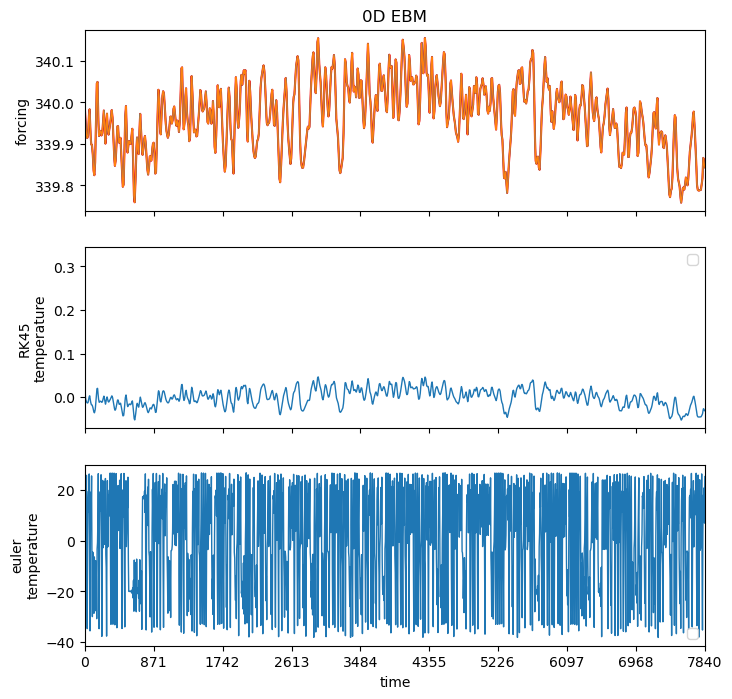

In [287]:
end_kya=max(tsi_time)
# plot_time_length = length-100
start_kya=min(tsi_time)#end_kya-plot_time_length

model_sols = [ebm_tsi_rk45, ebm_tsi_euler]

t_range = np.arange(start_kya, end_kya, 1)
ticks = np.linspace(start_kya, end_kya, 10)  # Generate 6 ticks from 800 to 3000
tick_labels = [str(int(tick)) for tick in ticks]  # Calculate labels 800 to 0

fig, ax = plt.subplots(len(model_sols)+1, 1, sharex=True, figsize=(8, 8))

for ik, model_sol in enumerate(model_sols):
    time = model_sol.solution.t#['t_arr']
    time_mask = time>=start_kya
    model_sol_y = model_sol.solution.y[:,0]
     
    model_forcing = model_sol.model.forcing.get_forcing(time[time_mask])
    label=None#','.join([r'$v_c=$'+str(model_sol.model.vc)])
    ax[ik+1].plot(time[time_mask], model_sol_y[time_mask]-np.mean(model_sol_y[time_mask]), linewidth=1,label=label) # marker='o', markersize=4, 
        
    ax[ik+1].legend()
    if ik ==0:
        ax[0].plot(t_range, model_sol.model.forcing.get_forcing(t_range), label='smooth', color='red')
    ax[0].plot(time[time_mask], model_forcing, linewidth=1, label=label)
    # ax[ik+1].set_ylim([-.5, .5])
    ax[ik+1].set_xticks(ticks)
    ax[ik+1].set_ylabel('\n'.join([model_sol.method,model_sol.model.variable_name]))
    ax[ik+1].set_xlim([start_kya, end_kya])
    
ax[-1].set_xticklabels(tick_labels)
ax[-1].set_xlabel('time')
ax[0].set_xlim([start_kya, end_kya])
ax[0].set_title('0D EBM')
ax[0].set_ylabel('forcing')